# Understanding and Predicting Loan Eligibility

## Loan Predictions (Imbalanced Classification)
***

## Table of Contents
### Part 1: DEFINE
- [Problem Statement](#problem)

### Part 2: DISCOVER
- [Load Data](#loaddata)
- [Simple Inspection of Data](#inspection)
- [Exploratory Data Analysis](#eda)
- [Preprocessing: Categorical and Numerical Variables](#preprocess)
- [Baseline Model & Performance](#baseline)
- [Hypothesize Solutions](#models)

### Part 3: DEVELOP
- [Model Training](#createmodels)
- [Model Testing](#testmodels)
- [Select the Best Model](#bestmodel)

### Part 4: DEPLOYMENT
- [Automate Pipeline](#autopipeline)
- [Deploy a Solution](#deployment)
- [Measure Efficacy](#efficacy)










# Part 1 - DEFINE

<a id='problem'></a>
### ---- 1 Define the problem ----

Data Source: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

[Dream Housing Finance](https://dreamhomefinancing.com) company provides mortgage lending solutions to home buyers. Using this partial dataset they provided, the company wants to automate the loan eligibility process (in real-time) based on customer information provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. 

In [1]:
%load_ext watermark
%watermark -a 'Vusal Babashov' -u -d -v -p numpy,mlxtend,matplotlib,scikit-learn

Author: Vusal Babashov

Last updated: 2021-04-28

Python implementation: CPython
Python version       : 3.8.2
IPython version      : 7.22.0

numpy       : 1.19.2
mlxtend     : 0.18.0
matplotlib  : 3.3.4
scikit-learn: 0.24.1



In [2]:
#import your libraries
import pandas as pd
import sklearn as sk
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, \
                            confusion_matrix, roc_curve, matthews_corrcoef


from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter


__author__ = "Vusal Babashov"
__email__ = "vbabashov@gmail.com"

## Part 2 - DISCOVER

<a id='loaddata'></a>
### ---- 2 Load the data ----

In [3]:
#load the data into a Pandas dataframe
data = pd.read_csv("/Users/vusalbabashov/Desktop/loan-classification/data/raw/loan_data_set.csv")

<a id='inspection'></a>
### ---- 3 Examine the data ----

In [4]:
#check a few rows
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
#look for duplicate data
data.duplicated().sum()

0

In [6]:
# check if there is a missing value in each column and how many missing cells for the dataset
with pd.option_context('display.max_rows', None):
    display(data.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
# check the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


<a id='eda'></a>
### ---- 4 Explore the data (EDA) ----

In [8]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features
data.describe(include = [np.number])

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [9]:
data.describe(include = ['O'])

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001528,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [10]:
# Check the class imbalance
data.Loan_Status.value_counts()/data.shape[0]

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

<AxesSubplot:xlabel='Loan_Status', ylabel='count'>

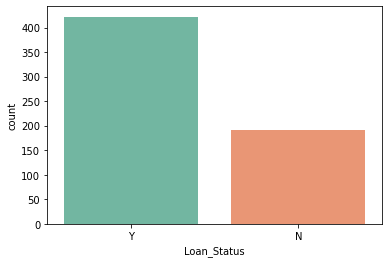

In [11]:
sns.countplot(x = "Loan_Status", data=data, palette = "Set2")

There is a class imbalance of 69% for Loan and 31% of No Loan.

In [12]:
categorical_vars = ['Gender', 'Married', 'Dependents', 'Education', 
                    'Self_Employed', 'Property_Area', 'Credit_History']
numerical_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

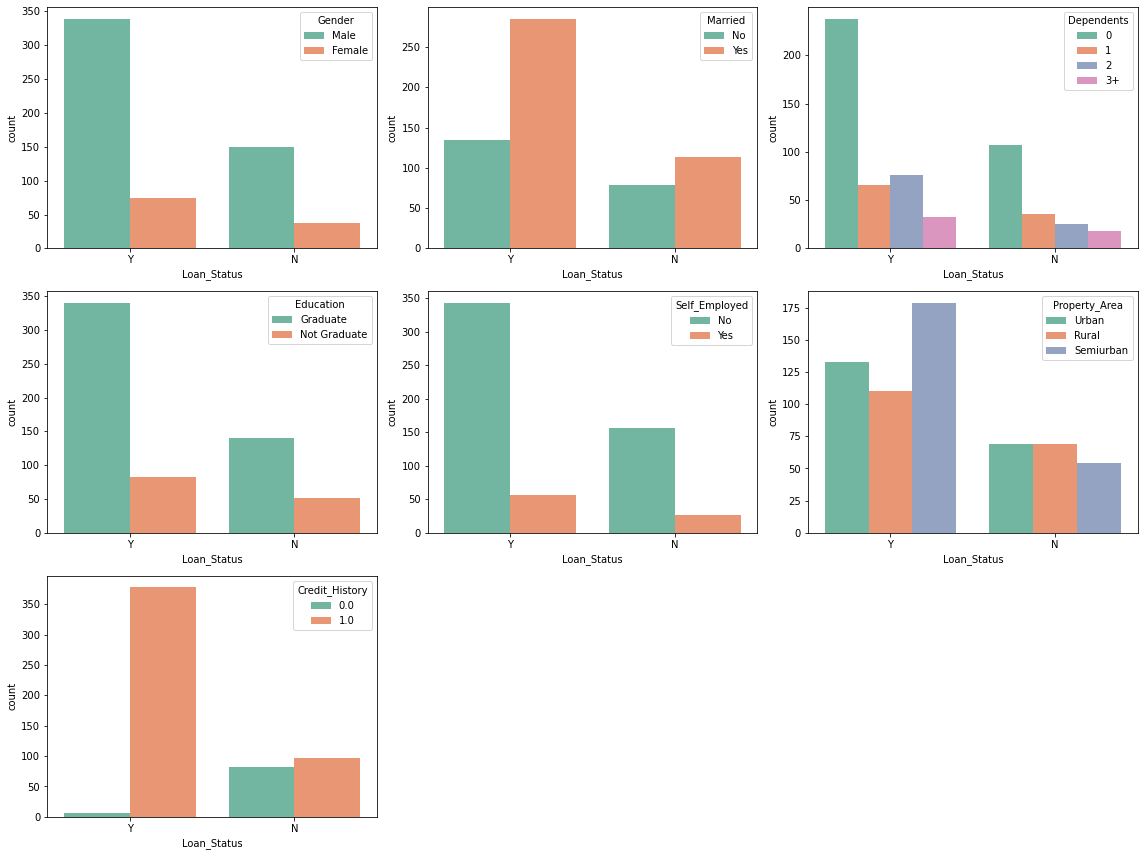

In [13]:
plt.figure (figsize= (16, 12))
for count, value in enumerate(categorical_vars):
    plt.subplot(3, 3, count+1)
    sns.countplot(x = "Loan_Status", hue=value, data=data, palette = "Set2")
plt.tight_layout()
plt.show()

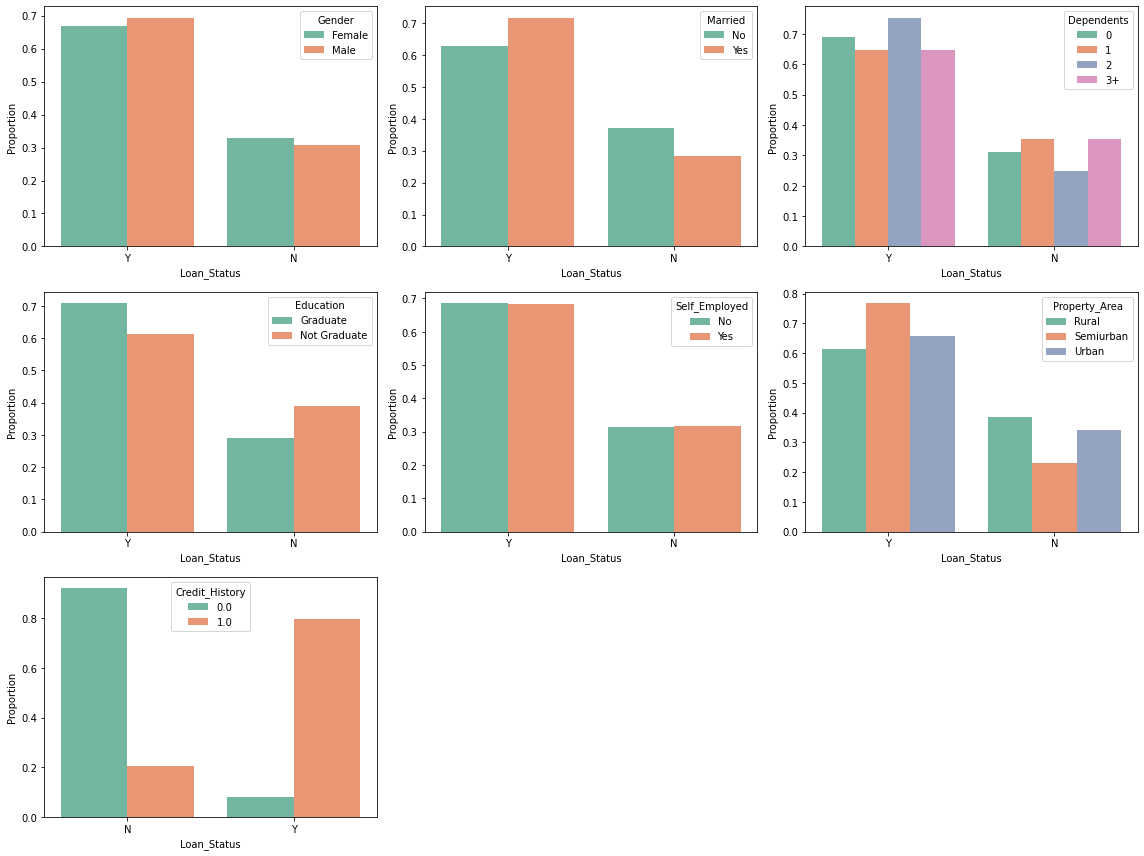

In [14]:
plt.figure (figsize= (16, 12))
for count, value in enumerate(categorical_vars):
    plt.subplot(3, 3, count+1)
    sns.barplot(data = data["Loan_Status"].groupby(data[value]).value_counts(normalize=True).reset_index(name='Proportion') , 
                        x = 'Loan_Status', 
                        y = 'Proportion',
                        hue = value,
                        palette="Set2")
plt.tight_layout()
plt.show()

**Summary**
Distribution of values for each categorical feature are close given the Loan Status class labels! However, Credit History seems to have an explanatory power because
- vast majority (95%+) of rejected applications have no credit history
- approximately, 80% of approved applications have a prior credit history

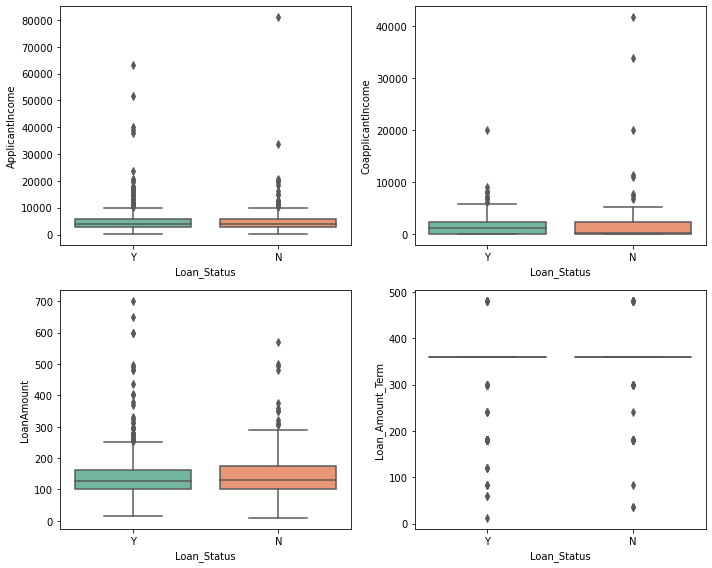

In [15]:
plt.figure (figsize= (10, 8))
for count, value in enumerate(numerical_vars):
    plt.subplot(2, 2, count+1)
    sns.boxplot(x="Loan_Status", y=value, palette = "Set2", data=data)
plt.tight_layout()
plt.show()

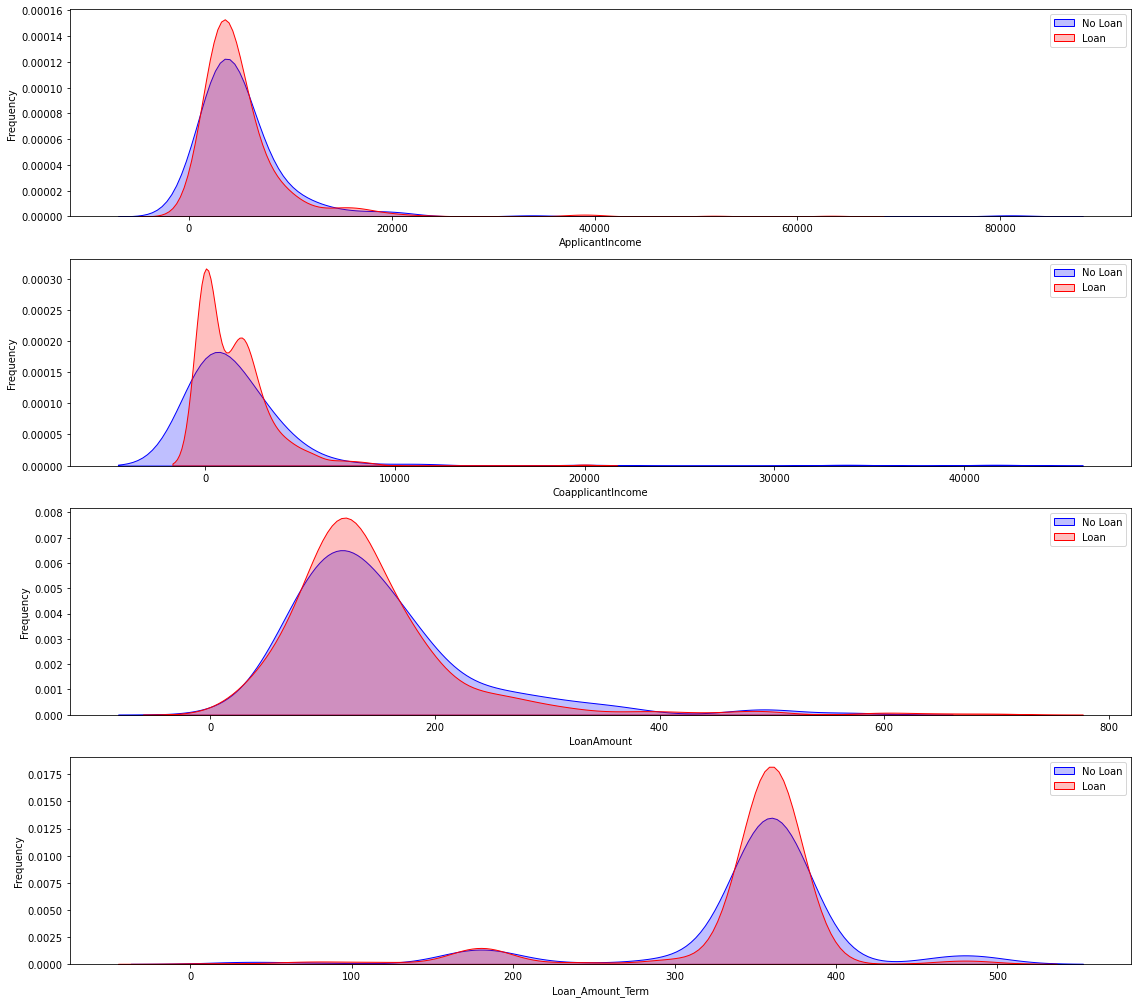

In [16]:
#KDEPlot: Kernel Density Estimate Plot
fig=plt.figure(figsize=(16,14))
for count, value in enumerate(numerical_vars):
    plt.subplot(4, 1, count+1)
    ax=sns.kdeplot(data.loc[(data['Loan_Status'] == 'N'), value], color='b', shade=True,label ='No Loan')
    ax=sns.kdeplot(data.loc[(data['Loan_Status'] == 'Y'), value], color='r', shade=True, label='Loan')
    ax.set(xlabel=value, ylabel='Frequency')
    ax.legend(labels=['No Loan','Loan'])
plt.tight_layout()
plt.show()

**Summary**
- Average Applicant Income for approved and rejected loans are about the same.
- Those who are approved had either zero or ~ 2500 of Coapplicant income.
- Requested loan amounts for approved and rejected loans are equal on average
- Loan applications are either for less 180 or 360 months term.

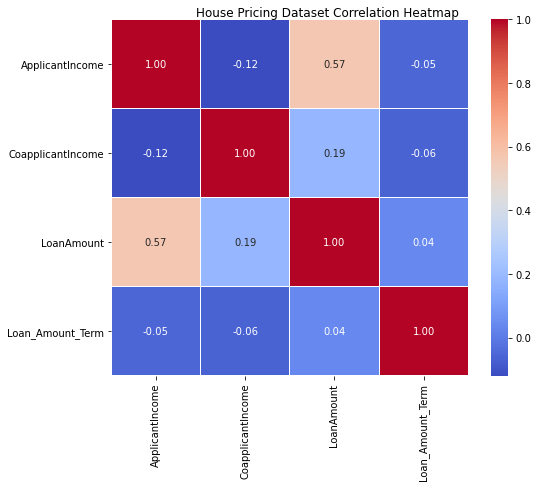

In [17]:
 # Create a correlation matrix.
f, ax = plt.subplots(figsize=(8, 6))
corr = data[numerical_vars].corr(method='pearson') 
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.95)
t = f.suptitle('House Pricing Dataset Correlation Heatmap', fontsize=12)

**Summary**

- There is no collinearity between the features
- Highest correlation coefficient is 0.57 between the Loan Amount and Applicant Income which makes sense

<a id='preprocess'></a>
### PreProcessing Steps 

- Missing Value Imputation
- Ordinal, One Hot Encoding 

In [18]:
def impute_missing_values (df, categorical_features, numeric_features):
    ''' Imputes the continious columns with median and categorical columns with the mode value'''
    imputer_con = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    for col in categorical_features+numeric_features:
        if df[col].isnull().sum() > 0:    
            if col in categorical_features:              
                df[col] = imputer_cat.fit_transform(df[col].values.reshape(-1,1))
            elif col in numeric_features:  
                df[col] = imputer_con.fit_transform(df[col].values.reshape(-1,1))
    return df                                                                  

In [19]:
data = impute_missing_values (data, categorical_vars, numerical_vars)

In [20]:
def preprocess (df,cat_cols, num_cols):
    ''' Drops ID, does one-hot encoding and changes data type for the ApplicantIncome'''
    dependent_mapping = {
           '0': 0,
           '1': 1,
           '2': 2,
           '3+': 3}
    df['Dependents'] = df['Dependents'].map(dependent_mapping) #map string values to ordinal integers
    df = df.drop(['Loan_ID'], axis=1) #drop the ID columns as it's not informative
    df['ApplicantIncome']=df['ApplicantIncome'].astype('float')
    categorical_df = pd.get_dummies(df[cat_cols], drop_first=True) #one-hot encoding on nominal variables
    numerical_df = df[num_cols]
    final_df = pd.concat([categorical_df,numerical_df,df['Loan_Status']], axis=1) #concat all three dfs
    return final_df

In [21]:
new_df = preprocess (data, categorical_vars, numerical_vars)

In [22]:
new_df.head()

,Dependents,Credit_History,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,0,1.0,1,0,0,0,0,1,5849.0,0.0,128.0,360.0,Y
1,1,1.0,1,1,0,0,0,0,4583.0,1508.0,128.0,360.0,N
2,0,1.0,1,1,0,1,0,1,3000.0,0.0,66.0,360.0,Y
3,0,1.0,1,1,1,0,0,1,2583.0,2358.0,120.0,360.0,Y
4,0,1.0,1,0,0,0,0,1,6000.0,0.0,141.0,360.0,Y


Let's split our data into a train and test set. We'll fit our model with the train set and leave our test set for our last evaluation.

In [23]:
# Create the X and y set
X = new_df.iloc[:,:-1]
y = new_df.iloc[:,-1]

# Define train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123, stratify=y)

<a id='baseline'></a>
### ---- 5 Establish a baseline ----

We establish a Naive Classifier where we predict class labels using a stratified random class logic, and use the ROC-AUC metric a performance measure.

In [24]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=1)
dummy_clf.fit(X_train, y_train)
roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])

0.5195046439628483

<a id='models'></a>
### ---- 6 Hypothesize solution ----

<a id='resample'></a>
### Resample Methods

Let's train a base logistic regression model on the three types of sampling methods to see which yields the best result:
1. **Orginal Sample**
2. **Oversampling**
3. **Undersampling**

In [25]:
print('Original dataset shape %s' % Counter(y_train))
# Oversampling Using SMOTE
sm = SMOTE(random_state=12)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print('Oversampled dataset shape %s' % Counter(y_train_sm))
rus = RandomUnderSampler(random_state=12)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
print('Undersampled dataset shape %s' % Counter(y_train_rus))

Original dataset shape Counter({'Y': 337, 'N': 154})
Oversampled dataset shape Counter({'Y': 337, 'N': 337})
Undersampled dataset shape Counter({'N': 154, 'Y': 154})


In [26]:
# Create the Original, Upsampled, and Downsampled training sets
methods_data = {"Original": (X_train, y_train),
                "Undersampled": (X_train_rus, y_train_rus),
                "SMOTE":(X_train_sm, y_train_sm)}

# Loop through each type of training sets and apply 5-Fold CV using Logistic Regression
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(LogisticRegression(max_iter=200), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best AUC Score for {method} data:")
    print (lr_results.mean())

The best AUC Score for Original data:
0.7698763771276445
The best AUC Score for Undersampled data:
0.782115851543531
The best AUC Score for SMOTE data:
0.8532838441680971


**From the above analysis, SMOTE results in better performance, so I'll use this sampling technique for model training.**

We will train following three methods based on interpretability and model performance

- Logistic Regression
- Random Forest 
- Xgboost 

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

### ---- 7 Engineer features  ----

In [27]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

For now, I'll skip this step and choose not to create additional features.

<a id='createmodels'></a>
### ---- 8 Create models ----

In [28]:
#create and tune the models that you brainstormed during part 2
lr = LogisticRegression(max_iter=150, random_state=1)

# Fit the model to the Upsampling data
lr.fit(X_train_sm, y_train_sm)

print ("\n\n ---Logistic Regression Model---")
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

print ("Logistic Regression AUC = %2.2f" % lr_auc)
print(classification_report(y_test, lr.predict(X_test)))



 ---Logistic Regression Model---
Logistic Regression AUC = 0.73
              precision    recall  f1-score   support

           N       0.77      0.45      0.57        38
           Y       0.79      0.94      0.86        85

    accuracy                           0.79       123
   macro avg       0.78      0.69      0.71       123
weighted avg       0.79      0.79      0.77       123



In [29]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train_sm, y_train_sm)

print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.77
              precision    recall  f1-score   support

           N       0.80      0.42      0.55        38
           Y       0.79      0.95      0.86        85

    accuracy                           0.79       123
   macro avg       0.79      0.69      0.71       123
weighted avg       0.79      0.79      0.77       123



In [30]:
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train_sm, y_train_sm)

print ("\n\n ---XGBoost Model---")
xgb_roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
print ("Random Forest AUC = %2.2f" % xgb_roc_auc)
print(classification_report(y_test, xgb.predict(X_test)))

[14:47:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 ---XGBoost Model---
Random Forest AUC = 0.76
              precision    recall  f1-score   support

           N       0.64      0.61      0.62        38
           Y       0.83      0.85      0.84        85

    accuracy                           0.77       123
   macro avg       0.73      0.73      0.73       123
weighted avg       0.77      0.77      0.77       123



/Users/vusalbabashov/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<a id='testmodels'></a>
### ---- 9 Test models ----

In [31]:
#do 5x2-fold nested cross validation on models and measure ROC_AUC score to select the best algorithm
def nested_cross_validation(features, target):
    '''This function performs the nested 5x2cv procedure and selects best algorithm'''
         
    gridcvs = {}
            
    clf1 = LogisticRegression(random_state=1)
    clf2 = RandomForestClassifier(random_state=1)
    clf3 = XGBClassifier(random_state=1)   
        
            
    param_grid1 = {'C': [0.01, 0.1, 1, 10, 100],
                   'penalty': ['l1', 'l2']}
    
    param_grid2 = {'n_estimators': [10, 100, 500, 1000, 10000]}
        
        
    param_grid3 = {'colsample_bytree':[0.6, 0.8], 
                         'max_depth': [8,10],
                         'min_child_weight':[3,7], 
                         'regsubsample' :[0.6, 0.8]}
        
   
    inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

    
    for pgrid, est, name in zip((param_grid1, param_grid2, param_grid3),
                                    (clf1, clf2, clf3),
                                    ('Logistic','RandomForest','Xgboost')):

        gcv = GridSearchCV(estimator=est,
                           param_grid=pgrid,
                           scoring = 'roc_auc',
                           n_jobs=-1,                              
                           cv=inner_cv,
                           verbose=0,
                           refit=True)
            
        gridcvs[name] = gcv


    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    
    for name, gs_est in sorted(gridcvs.items()):
        nested_score = cross_val_score(gs_est, 
                                       X=features, 
                                       y=target,                                            
                                       cv=outer_cv,
                                        n_jobs=-1)
        print('%s | outer ROC_AUC %.2f%% +/- %.2f' % 
                  (name, nested_score.mean(), nested_score.std()))
            

In [32]:
nested_cross_validation(X_train_sm, y_train_sm)

Logistic | outer ROC_AUC 0.86% +/- 0.02
RandomForest | outer ROC_AUC 0.89% +/- 0.01
Xgboost | outer ROC_AUC 0.89% +/- 0.01


**Determine the best algorithm from the experiment above; e.g., we find that Random Forest (or Xgboost) is performing best**

<a id='bestmodel'></a>
### ---- 10 Select best model  ----

In [33]:
def tune_best_algorithm (est,feature_train, target_train, feature_test, target_test): 
    '''This function performs hyperparameter tuning on the whole training set with the best algorithm '''
        
    param_grid2 = {'n_estimators': [10, 100, 500, 1000, 10000]}
        
    gcv_model_select = GridSearchCV(estimator= est,
                                        param_grid=param_grid2,
                                        scoring='roc_auc',
                                        n_jobs=-1,
                                        cv = 5,
                                        verbose=1,
                                        refit=True)

    gcv_model_select.fit(feature_train, target_train)   
    
    
    best_model = gcv_model_select.best_estimator_
    
    
    train_roc = roc_auc_score(target_train, best_model.predict_proba(feature_train)[:, 1])
    test_roc  = roc_auc_score(target_test,  best_model.predict_proba(feature_test)[:, 1])
    
    print('ROC-AUC %.2f (average over k-fold CV test folds)' %
      (gcv_model_select.best_score_))
    print('Best Parameters: %s' % gcv_model_select.best_params_)
    
    print('Training ROC-AUC: %.2f' % (train_roc))
    print('Test ROC-AUC: %.2f' % (test_roc))
    
    return best_model

In [34]:
#select the model with the best ROC-AUC as your "production" model
selected_model=tune_best_algorithm (RandomForestClassifier(random_state=1), X_train_sm, y_train_sm, X_test, y_test)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
ROC-AUC 0.90 (average over k-fold CV test folds)
Best Parameters: {'n_estimators': 10000}
Training ROC-AUC: 1.00
Test ROC-AUC: 0.79


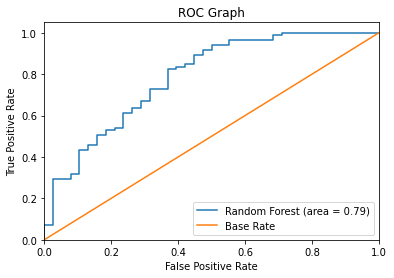

In [35]:
# Create ROC Graph
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, selected_model.predict_proba(X_test)[:,1], pos_label='Y')

plt.figure()

# Plot Random Forest ROC
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc_score(y_test,  selected_model.predict_proba(X_test)[:, 1]))

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [36]:
#Confusion Matrix
confusion_matrix(y_test, selected_model.predict(X_test))

array([[17, 21],
       [ 4, 81]])

In [37]:
#Matthew's Correlation Coefficient
matthews_corrcoef(y_test, selected_model.predict(X_test))

0.4915724448470683

In [38]:
# Get Feature Importances
feature_importances = pd.DataFrame(selected_model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,Credit_History,0.352539
1,ApplicantIncome,0.175454
2,LoanAmount,0.147111
3,CoapplicantIncome,0.096618
4,Dependents,0.044994
5,Property_Area_Semiurban,0.043595
6,Loan_Amount_Term,0.036657
7,Property_Area_Urban,0.026044
8,Married_Yes,0.024811
9,Education_Not Graduate,0.019571


<AxesSubplot:xlabel='importance', ylabel='index'>

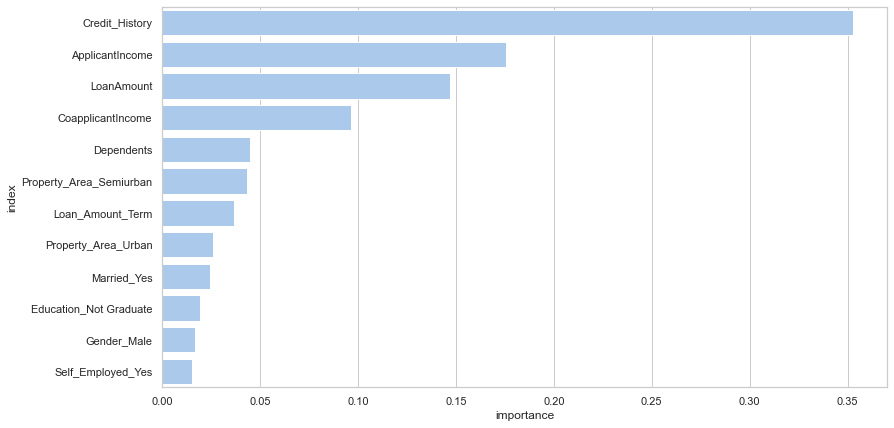

In [39]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

## Part 4 - DEPLOY

<a id='autopipeline'></a>
### ---- 11 Automate pipeline ----

In [40]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

<a id='deployment'></a>
### ---- 12 Deploy solution ----

In [41]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

<a id='efficacy'></a>
### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data